# Drug Risk Analysis 

## Introduction

This project aims at unraveling the relationship between personality traits and drug consumption. First, the normalized data is coded into more apprehensible categories. Next we will explore the data to get an overview and a deeper understanding of it.
After that we will discuss a selection of business cases we decided to develop. Since this project is for training purposes and there are already a lot of good analyses online, we opted for a more lighthearted approach.

## About the data set

The data set can be found [here](https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29) (07/01/2020).
The link includes the following description:

"Database contains records for 1885 respondents. For each respondent 12 attributes are known: Personality measurements which include NEO-FFI-R (neuroticism, extraversion, openness to experience, agreeableness, and conscientiousness), BIS-11 (impulsivity), and ImpSS (sensation seeking), level of education, age, gender, country of residence and ethnicity. All input attributes are originally categorical and are quantified. After quantification values of all input features can be considered as real-valued. In addition, participants were questioned concerning their use of 18 legal and illegal drugs (alcohol, amphetamines, amyl nitrite, benzodiazepine, cannabis, chocolate, cocaine, caffeine, crack, ecstasy, heroin, ketamine, legal highs, LSD, methadone, mushrooms, nicotine and volatile substance abuse and one fictitious drug (Semeron) which was introduced to identify over-claimers. For each drug they have to select one of the answers: never used the drug, used it over a decade ago, or in the last decade, year, month, week, or day.
Database contains 18 classification problems. Each of independent label variables contains seven classes: "Never Used", "Used over a Decade Ago", "Used in Last Decade", "Used in Last Year", "Used in Last Month", "Used in Last Week", and "Used in Last Day"."



## Variables
ordinal, ratio, nominal, dichotomus

|Variable|Definition|Key|Type|
|:-------|:---------|:--------|:--------|
|age|Groups of age range|0=18-24, 1=25-34, 2=35-44, 3=45-54, 4=55-64, 5=65+|ordinal|
|gender|sex of participant|0=Female, 1 =Male|dichotomous|
|education|Educational level of the participant|Left school before 16 years, Left school at 16 years, Left school at 17 years, Left school at 18 years, Some college or university, no certificate or degree, Professional certificate/ diploma, University degree, Masters degree, Doctorate degree|ordinal|
|country|Country of current residence of the participant|Australia, Canada, New Zealand, Other, Republic of Ireland, UK, USA|categorical|
|ethnicity|Ethnicity of the participant|Asian, Black, Mixed-Black/Asian, Mixed-White/Asian, Mixed-White/Black, Other, White|categorical|
|Nscore|NEO-FFI-R test neuroticism|Scale from 1 to 60|ordinal|
|Escore|NEO-FFI-R test extraversion|Scale from 1 to 60|ordinal|
|Oscore|NEO-FFI-R test openness to experience|Scale from 1 to 60|ordinal|
|Ascore|NEO-FFI-R test agreeableness|Scale from 1 to 60|ordinal|
|Cscore|NEO-FFI-R test conscientiousness|Scale from 1 to 60|ordinal|
|impulsiveness|Impulsiveness measured by BIS-11|Groups from 1 to 12|ordinal|
|ss|sensation seeking measured by ImpSS|Groups from 1 to 12|ordinal|
|drug|18 different substances  with frequency of usage|0=Never Used, 1=Used over a Decade Ago, 2=Used in Last Decade, 3=Used in Last Year, 4=Used in Last Month, 5=Used in Last Week, 6=Used in Last Day|ordinal|
|drug_user|18 different substances with binary variable for usage|0=no usage, 1=usage|dichotomous|


In [44]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from math import pi
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split,cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor,AdaBoostClassifier ,RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report, r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

## Data Cleaning

Even though the data is comprehensive we decided to not use some of the data. Also we had to translate the normalized data into more apprehensible categories.

In [4]:
df = pd.read_excel('Drug_Risk.xls')

In [5]:
df.shape

(1885, 32)

In [6]:
df.columns = [c.lower() for c in df.columns] #changes all titles to lower case letters, this is the way.

In [7]:
df.head()

,id,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,...,ecstasy,heroin,ketamine,legalh,lsd,meth,shrooms,nicotine,semer,vsa
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


Semeron is a made up substance to test if Participants are exxagerating their consumption.
There a 8 participants that claimed to use Semeron. They can be filtered out since their other replies are not reliable either.
Notice that six of them are between 18 and 24 years old.

In [8]:
df[df.semer != 'CL0']

,id,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,...,ecstasy,heroin,ketamine,legalh,lsd,meth,shrooms,nicotine,semer,vsa
727,730,-0.07854,0.48246,-1.73790,-0.09765,-0.31685,-0.58016,0.32197,0.14143,-0.60633,...,CL2,CL2,CL2,CL0,CL4,CL2,CL6,CL6,CL2,CL2
817,821,-0.95197,-0.48246,-0.61113,-0.09765,-0.50212,-0.67825,1.74091,0.72330,0.13136,...,CL3,CL0,CL0,CL0,CL5,CL0,CL5,CL4,CL3,CL0
1516,1520,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,-0.80615,-1.27553,-1.34289,...,CL1,CL2,CL1,CL2,CL1,CL2,CL4,CL2,CL3,CL1
1533,1537,-0.95197,0.48246,-0.61113,-0.57009,0.11440,-0.46725,0.80523,0.29338,2.03972,...,CL4,CL0,CL4,CL3,CL2,CL0,CL3,CL4,CL4,CL3
1698,1702,0.49788,0.48246,0.45468,-0.57009,-0.31685,1.98437,-0.80615,2.15324,0.76096,...,CL2,CL0,CL2,CL2,CL2,CL0,CL2,CL6,CL2,CL0
1769,1773,-0.95197,-0.48246,-1.22751,-0.57009,-0.22166,-0.34799,1.28610,1.06238,-0.01729,...,CL3,CL0,CL4,CL3,CL6,CL3,CL3,CL3,CL1,CL3
1806,1810,-0.95197,0.48246,-1.43719,-0.57009,-0.31685,1.23461,1.11406,1.06238,-1.47955,...,CL4,CL2,CL1,CL4,CL1,CL0,CL1,CL6,CL1,CL2
1823,1827,-0.95197,0.48246,0.45468,-0.57009,-0.31685,0.22393,-0.30033,0.88309,1.28610,...,CL0,CL0,CL0,CL2,CL3,CL0,CL3,CL5,CL2,CL0


In [9]:
df = df[df.semer == 'CL0'] #deletes the information about the participants that overclaimed their substance uses

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1877 entries, 0 to 1884
Data columns (total 32 columns):
id           1877 non-null int64
age          1877 non-null float64
gender       1877 non-null float64
education    1877 non-null float64
country      1877 non-null float64
ethnicity    1877 non-null float64
nscore       1877 non-null float64
escore       1877 non-null float64
oscore       1877 non-null float64
ascore       1877 non-null float64
cscore       1877 non-null float64
impulsive    1877 non-null float64
ss           1877 non-null float64
alcohol      1877 non-null object
amphet       1877 non-null object
amyl         1877 non-null object
benzos       1877 non-null object
caff         1877 non-null object
cannabis     1877 non-null object
choc         1877 non-null object
coke         1877 non-null object
crack        1877 non-null object
ecstasy      1877 non-null object
heroin       1877 non-null object
ketamine     1877 non-null object
legalh       1877 non-null objec

1877 data points with useful information. Time to make the information readable. For that we use the listing given on the description page.

In [11]:
dict_age = {'-0.95197': '18-24','-0.07854': '25-34', '0.49788': '35-44','1.09449': '45-54','1.82213': '55-64',
            '2.59171': '65+'}

dict_sex = {'0.48246':'Female','-0.48246': 'Male'}

dict_edu = {'-2.43591': 'left_school','-1.7379': 'left_school','-1.43719': 'left_school_at_17_years',
           '-1.22751': 'left_school_at_18 years','-0.61113': 'Some college or university, no certificate or degree',
           '-0.05921': 'professional_certificate/ diploma', '0.45468': 'university_degree',
           '1.16365': 'masters_degree', '1.98437': 'doctorate_degree'}

dict_cou = {'-0.09765': 'Australia', '0.24923': 'Canada', '-0.46841': 'New Zealand', '-0.28519': 'Other',
            '0.21128': 'Republic of Ireland','0.96082': 'UK','-0.57009': 'USA'}

dict_eth = {'-0.50212':'Asian','-1.10702': 'Black','1.90725': 'Mixed-Black/Asian',
            '0.126': 'Mixed-White/Asian','-0.22166' :'Mixed-White/Black','0.1144': 'Other'
            ,'-0.31685': 'White'}

In [12]:
df.age = [dict_age[str(a)] for a in df.age]
df.gender = [dict_sex[str(a)]  for a in df.gender]
df.education = [dict_edu[str(a)] for a in df.education]
df.country = [dict_cou[str(a)] for a in df.country]
df.ethnicity = [dict_eth[str(a)] for a in df.ethnicity]

In [13]:
df.head()

,id,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,...,ecstasy,heroin,ketamine,legalh,lsd,meth,shrooms,nicotine,semer,vsa
0,1,35-44,Female,professional_certificate/ diploma,UK,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,25-34,Male,doctorate_degree,UK,White,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,35-44,Male,professional_certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,18-24,Female,masters_degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,35-44,Female,doctorate_degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


Way better! Now we make some collections to call on the data.
In addition we define a "user" as someone who consumed the substance in the last month, therefore has claimed either CL4 or higher.

In [14]:
drugs = ['alcohol',
       'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack',
       'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'shrooms',
       'nicotine', 'semer', 'vsa']

for d in drugs:
    df[d + '_user'] = [u in ('CL4', 'CL5', 'CL6') for u in df[d]]
    
drug_labels = ['Alcohol',
       'Amphetamines', 'Amyl Nitrite', 'Benzodiazepine', 'Caffeine', 'Cannabis', 'Chocolate', 'Cocaine', 'Crack',
       'Ecstasy', 'Heroin', 'Ketamine', 'Legal Highs', 'LSD', 'Methadone', 'Magic Mushrooms',
       'Nicotine', 'Volatile Substances']

In [15]:
df[drugs].head()

,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,shrooms,nicotine,semer,vsa
0,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


Since the last time used is labeled from CL0 to CL6 we can drop the CL and use 0 to 6 instead.

In [16]:
for d in drugs:
    df[d] = [int(c[-1:]) for c in df[d]]

In [17]:
df[drugs].head()

,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,shrooms,nicotine,semer,vsa
0,5,2,0,2,6,0,5,0,0,0,0,0,0,0,0,0,2,0,0
1,5,2,2,0,6,4,6,3,0,4,0,2,0,2,3,0,4,0,0
2,6,0,0,0,6,3,4,0,0,0,0,0,0,0,0,1,0,0,0
3,4,0,0,3,5,2,4,2,0,0,0,2,0,0,0,0,2,0,0
4,4,1,1,0,6,3,6,0,0,1,0,0,1,0,0,2,2,0,0


Semeron is not real and used for checking if a participant exxagerates his drug habits. It can be dropped.

In [18]:
drugs.remove('semer')

For Plotting we need a translator dictionary.

In [19]:
drug_dict = {drugs[i]:drug_labels[i] for i in range(len(drugs))}

## Connection between substances

Which substances are used by the same person?  
In order to visualize it, we give every substance a node with the size relative to its frequency of occurrence.
Then we simulate a connection between them, that gets stronger with the number of participants that used both substances.

In [20]:
def plot_networkx_graph(G):
    '''
    Plots a networkx plot with spring_layout
    '''
    pos = nx.spring_layout(G, seed = round(pi))
    nx.draw_networkx_nodes(G, pos, node_size = list(map(int, nx.get_node_attributes(G, 'size').values())) , alpha = 0.5)
    nx.draw_networkx_edges(G, pos, width=0.1)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    #plt.figure(figsize = (16, 9))
    plt.style.use('default')
    plt.axis('off')
    plt.savefig('graphs/Drug_Correlations.png', bbox_inches = 'tight')
    plt.show()

In [21]:
G = nx.Graph()

G.add_nodes_from([(drug_dict[drug],dict(size =str(df[drug + '_user'][df[drug + '_user']].count()))) for drug in drugs])
weights = {}
for _, p in df.iterrows():
    for c, b in itertools.combinations(drugs, 2):
        weights[c + '_' + b] = sum(df[f'{c}_user'][df[f'{b}_user']])

G.add_weighted_edges_from([(drug_dict[key.split('_')[0]], drug_dict[key.split('_')[1]], weights[key]) for key in weights.keys()])


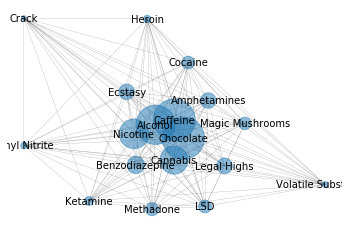

In [22]:
plot_networkx_graph(G)

Can it be improved? The weight should reflect how strongly the use of one drug correlates with the other. If substances are used more often, their over represented in the weight. To fix that we can use rates. What rate of the cannabis user also drink coffee and what percentage of coffee drinkers also use cannabis? Add both and use it as weight.

In [23]:
adjusted_weights = {}
for key in weights.keys():
    adjusted_weights[key] = weights[key]*(
        (1/df[key.split('_')[0] + '_user'][df[key.split('_')[0] + '_user']].count()) # 1/number of users of first part of key
        +(1/df[key.split('_')[1] + '_user'][df[key.split('_')[1] + '_user']].count())) # 1/number of users of second part of key
    
G.add_weighted_edges_from([(drug_dict[key.split('_')[0]], drug_dict[key.split('_')[1]], adjusted_weights[key]) for key in adjusted_weights.keys()])   

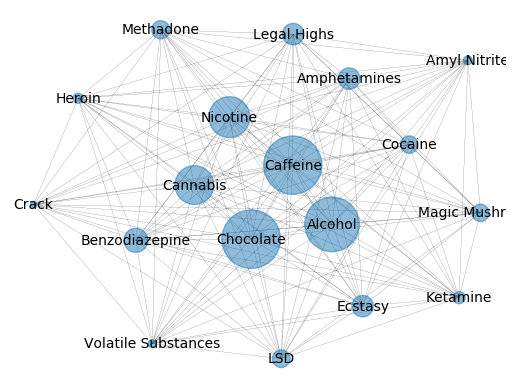

In [24]:
plot_networkx_graph(G)

## How does the age influence substance use?

In [25]:
for d in drugs:
    df[d + '_user'] = df[d + '_user'].astype(int)

In [26]:
df[[d + '_user' for d in drugs]].head()

,alcohol_user,amphet_user,amyl_user,benzos_user,caff_user,cannabis_user,choc_user,coke_user,crack_user,ecstasy_user,heroin_user,ketamine_user,legalh_user,lsd_user,meth_user,shrooms_user,nicotine_user,vsa_user
0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0
2,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [27]:
sns.set()
sns.set_style('whitegrid')
ages = sorted(list(df.age.unique()))
drug_user =[d + '_user' for d in drugs]
dat = []
for age in ages:
    dat.append([sum(df[df.age == age][d]) for d in drug_user])

In [28]:
plf = pd.DataFrame(data = dat, index = ages, columns = drug_labels)

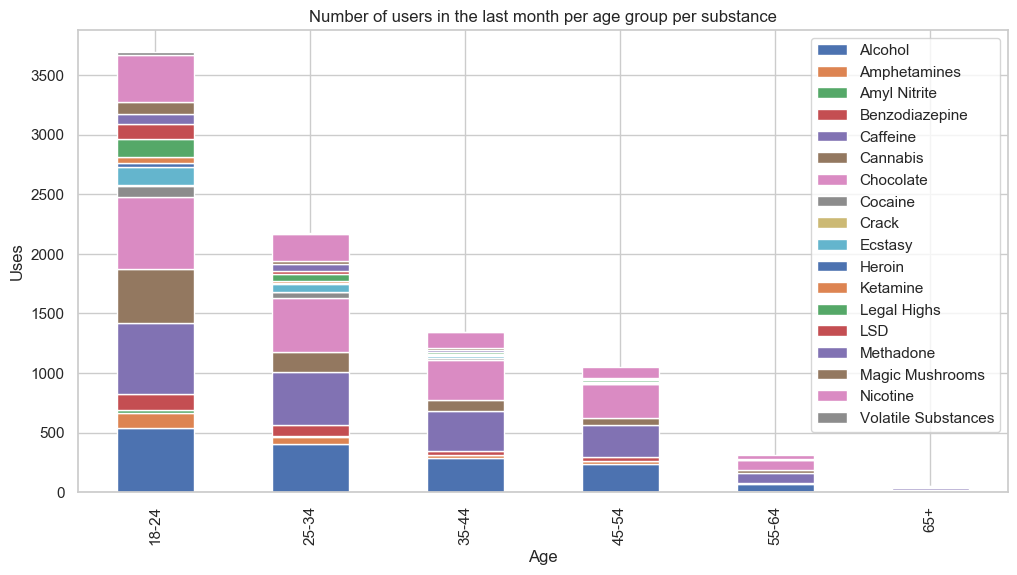

In [29]:
age_graph = plf.plot(kind = 'bar', stacked = True, figsize = (12,6))
plt.xlabel('Age')
plt.ylabel('Uses')
plt.title('Number of users in the last month per age group per substance')
plt.style.use('seaborn')
plt.savefig('graphs/uses_over_age.png', bbox_inches = 'tight')

That is hard to read, we'll only show the most important ones and combine the rest in others.

In [30]:
drug_freq = {s : sum(df[s + '_user']) for s in drugs}
drug_freq

{'alcohol': 1545,
 'amphet': 237,
 'amyl': 41,
 'benzos': 298,
 'caff': 1757,
 'cannabis': 781,
 'choc': 1780,
 'coke': 157,
 'crack': 20,
 'ecstasy': 238,
 'heroin': 53,
 'ketamine': 77,
 'legalh': 240,
 'lsd': 163,
 'meth': 171,
 'shrooms': 156,
 'nicotine': 869,
 'vsa': 34}

## How many people use how many different Substances?

Redefine 'user'.

In [31]:
for d in drugs:
    df[d + '_user'] = [int(u in (3,4,5,6)) for u in df[d]]

In [32]:
diff_subs = [0] * len(drugs)
for _, row in df.iterrows():
    row['number_of_substances'] = sum([row[d] for d in drug_user])
    diff_subs[row['number_of_substances']] += 1

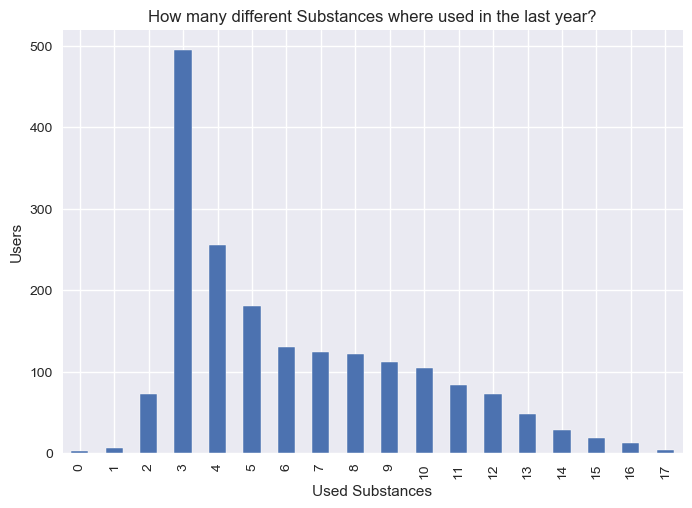

In [33]:
pd.DataFrame(enumerate(diff_subs, 0))[1].plot(kind = 'bar')
plt.xlabel('Used Substances')
plt.ylabel('Users')
plt.title('How many different Substances where used in the last year?')
plt.style.use('seaborn')
plt.savefig('graphs/substances_per_user.png', bbox_inches = 'tight')

## Other analysis

Gender

In [34]:
df.gender.value_counts()

Male      940
Female    937
Name: gender, dtype: int64

In [35]:
degrees = dict(df.education.value_counts())
degrees_labels = {'Some college or university, no certificate or degree': 'Some university',
 'university_degree': 'University',
 'masters_degree': 'Masters',
 'professional_certificate/ diploma': 'Professional',
 'left_school': 'Left School < 17y',
 'left_school_at_18 years': 'Left School at 18y',
 'doctorate_degree': 'Doctorate',
 'left_school_at_17_years': 'Left school at 17y'}

In [36]:
sorted_degree = {}
for i in [4, 7, 5, 0, 3, 1, 2, 6]:
    sorted_degree[degrees_labels[list(degrees.keys())[i]]] = list(degrees.values())[i]
sorted_degree

{'Left School < 17y': 126,
 'Left school at 17y': 29,
 'Left School at 18y': 99,
 'Some university': 503,
 'Professional': 270,
 'University': 478,
 'Masters': 283,
 'Doctorate': 89}

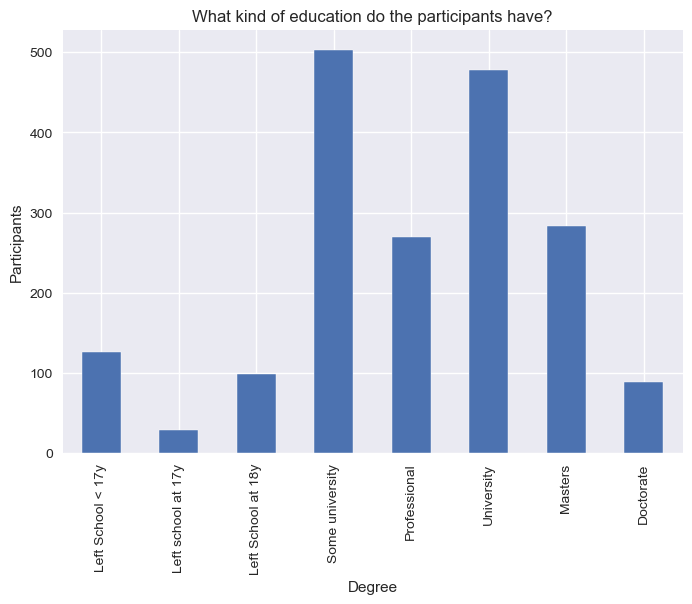

In [37]:
dfe = pd.DataFrame(sorted_degree.values(), index = sorted_degree.keys())
dfe.plot(kind = 'bar')
plt.xlabel('Degree')
plt.ylabel('Participants')
plt.title('What kind of education do the participants have?')
plt.style.use('seaborn')
plt.legend().remove()
plt.savefig('graphs/degrees.png', bbox_inches = 'tight')

# Feature Engineering

Dividing substances into different kind of drugs

In [38]:
soft_drugs = [ 'alcohol','caff','choc', 'nicotine']
middle_drugs = [ 'amyl','cannabis', 'ecstasy', 'ketamine', 'lsd','legalh','shrooms','vsa']
hard_drugs =  ['amphet','benzos', 'coke', 'crack', 'heroin', 'meth']

In [39]:
soft_drugs_bin = [ 'alcohol_user','caff_user','choc_user', 'nicotine_user']
middle_drugs_bin = [ 'amyl_user','cannabis_user', 'ecstasy_user', 'ketamine_user', 'lsd_user','legalh_user',
                    'shrooms_user','vsa_user']
hard_drugs_bin =  ['amphet_user','benzos_user', 'coke_user', 'crack_user', 'heroin_user', 'meth_user']

Generating a list for all the numerical features

In [40]:
num_features = list(df.columns[df.dtypes==float])

Defining lists of categories of columns

In [41]:
age = ['18-24','25-34','35-44','45-54','55-64','65+']
gender = ['Female','Male']
education = ['left_school','left_school','left_school_at_17_years',
             'left_school_at_18 years','Some college or university, no certificate or degree',
           'professional_certificate/ diploma','university_degree','masters_degree','doctorate_degree']
country = ['Australia','Canada','New Zealand','Other','Republic of Ireland','UK','USA']
ethnicity = ['Asian','Black','Mixed-Black/Asian','Mixed-White/Asian','Mixed-White/Black','Other','White']

Encoding ordinal features of the dataset

In [45]:
ordfeat = [age,education]
ordfeat1 = ['age','education']
for i in range(len(ordfeat)):
    encoder = OrdinalEncoder(categories=[ordfeat[i]])
    df[ordfeat1[i]] = encoder.fit_transform(df[ordfeat1[i]].values.reshape(-1, 1))

Encoding categorical features of the dataset

In [46]:
encoder = OneHotEncoder(dtype=np.int, sparse=True)
onehotfeat = ['gender','country','ethnicity']
nominals = pd.DataFrame(
    encoder.fit_transform(df[['gender', 'country','ethnicity']]).toarray(),
    columns=['Female', 'Male','Australia', 'Canada', 'New Zealand', 'Other_country','Republic of Ireland', 'UK','USA','Asian','Black','Mixed-Black/Asian', 'Mixed-White/Asian','Mixed-White/Black','Other_eth', 'White'])

Join the binary encoded columns with the original dataframe and get rid of overlapping data

In [47]:
df = df.join(nominals,rsuffix='L')
df.pop('semer')
df.pop('gender')
df.pop('country')
df.pop('ethnicity')
df.pop('semer_user')
df.pop('id')

0          1
1          2
2          3
3          4
4          5
5          6
6          7
7          8
8          9
9         10
10        11
11        12
12        13
13        14
14        15
15        16
16        17
17        18
18        19
19        20
20        21
21        22
22        23
23        24
24        25
25        26
26        27
27        28
28        29
29        30
        ... 
1855    1859
1856    1860
1857    1861
1858    1862
1859    1863
1860    1864
1861    1865
1862    1866
1863    1867
1864    1868
1865    1869
1866    1870
1867    1871
1868    1872
1869    1873
1870    1874
1871    1875
1872    1876
1873    1877
1874    1878
1875    1879
1876    1880
1877    1881
1878    1882
1879    1883
1880    1884
1881    1885
1882    1886
1883    1887
1884    1888
Name: id, Length: 1877, dtype: int64

Defining categorical features and set them as categorical features

In [48]:
categorical_features = ['age','education','alcohol','amphet', 'amyl', 'benzos', 'caff','cannabis', 'choc', 'coke', 'crack', 'ecstasy',
                        'heroin', 'ketamine', 'legalh', 'lsd','meth','shrooms', 'nicotine', 'vsa',
                        'alcohol_user','amphet_user','amyl_user','benzos_user','caff_user','cannabis_user',
                        'choc_user','coke_user','crack_user','ecstasy_user','heroin_user','ketamine_user',
                        'legalh_user','lsd_user','meth_user','shrooms_user','nicotine_user','vsa_user',
                        'Female','Male','Australia','Canada','New Zealand','Other_country','Republic of Ireland','UK','USA','Asian',
                        'Black','Mixed-Black/Asian','Mixed-White/Asian','Mixed-White/Black','Other_eth','White']

In [49]:
for i in categorical_features:
    df[i]= df[i].astype('category')

In [50]:
num_features = ['nscore','escore','oscore','ascore','cscore','impulsive','ss']

Defining binary classes of substances

In [51]:
drug_users = ['alcohol_user','amphet_user', 'amyl_user', 'benzos_user', 'caff_user', 'cannabis_user',
       'choc_user', 'coke_user', 'crack_user', 'ecstasy_user', 'heroin_user',
       'ketamine_user', 'legalh_user', 'lsd_user', 'meth_user', 'shrooms_user',
       'nicotine_user', 'vsa_user']

In [52]:
drug_users_list = {}
for i in drug_users:
    druggs = sum(df[i])
    drug_users_list.update({str(i):druggs})

Definging imbalanced columns in order to find best suiting models for these columns

In [53]:
imbalanced_sets_minor =['amyl_user', 'crack_user', 'heroin_user', 'ketamine_user',
                        'meth_user', 'vsa_user']
imbalanced_sets_major =['alcohol','caff_user', 'choc_user']

# Predictive modeling

## Train-test-split for every column

Before splitting the dataset we'll get rid of NaN values

In [54]:
df = df.dropna(axis=0, how='any')

### Train-test-split binary

Splitting the dataset into training sets. Split for each column to test binary drug usage.

In [55]:
dfbin = pd.DataFrame(df, columns=['age', 'education', 'nscore', 'escore', 'oscore', 'ascore', 'cscore',
       'impulsive', 'ss','alcohol_user',
       'amphet_user', 'amyl_user', 'benzos_user', 'caff_user', 'cannabis_user',
       'choc_user', 'coke_user', 'crack_user', 'ecstasy_user', 'heroin_user',
       'ketamine_user', 'legalh_user', 'lsd_user', 'meth_user', 'shrooms_user',
       'nicotine_user', 'vsa_user', 'Female', 'Male', 'Australia', 'Canada',
       'New Zealand', 'Other_country', 'Republic of Ireland', 'UK', 'USA',
       'Asian', 'Black', 'Mixed-Black/Asian', 'Mixed-White/Asian',
       'Mixed-White/Black', 'Other_eth', 'White'])

In [56]:
for d in dfbin.columns:
    X = dfbin.drop(d,axis=1)
    y = dfbin[d]
    globals()["X_train_bin_" + str(d)], globals()["X_test_bin_" + str(d)], globals()["y_train_bin_" + str(d)], globals()["y_test_bin_" + str(d)] = train_test_split(X, y, test_size=0.25, random_state=2)

### Train-test-split multiclass

Splitting the dataset into training sets. Split for each column to test multiclass drug usage.

In [57]:
dfmult = pd.DataFrame(df, columns=['age', 'education', 'nscore', 'escore', 'oscore', 'ascore', 'cscore',
       'impulsive', 'ss', 'alcohol', 'amphet', 'amyl', 'benzos', 'caff',
       'cannabis', 'choc', 'coke', 'crack', 'ecstasy', 'heroin', 'ketamine',
       'legalh', 'lsd', 'meth', 'shrooms', 'nicotine', 'vsa', 'Female', 'Male', 'Australia', 'Canada',
       'New Zealand', 'Other_country', 'Republic of Ireland', 'UK', 'USA',
       'Asian', 'Black', 'Mixed-Black/Asian', 'Mixed-White/Asian',
       'Mixed-White/Black', 'Other_eth', 'White'])

In [58]:
for d in dfmult.columns:
    X = dfmult.drop(d,axis=1)
    y = dfmult[d]
    globals()["X_train_mult_" + str(d)], globals()["X_test_mult_" + str(d)], globals()["y_train_mult_" + str(d)], globals()["y_test_mult_" + str(d)] = train_test_split(X, y, test_size=0.25, random_state=2)

## Function for binary classification

Setting up the binary class function

In [59]:
mean_acc_bin = []

In [62]:
df = df.dropna(axis=0, how='any')

In [63]:
cat_features_bin = ['age','education','alcohol_user','amphet_user','amyl_user','benzos_user','caff_user','cannabis_user',
                        'choc_user','coke_user','crack_user','ecstasy_user','heroin_user','ketamine_user',
                        'legalh_user','lsd_user','meth_user','shrooms_user','nicotine_user','vsa_user',
                        'Female','Male','Australia','Canada','New Zealand','Other_country','Republic of Ireland','UK','USA','Asian',
                        'Black','Mixed-Black/Asian','Mixed-White/Asian','Mixed-White/Black','Other_eth','White']

In [82]:
def catclassifier(goal,classifier):
    X_train, X_test, y_train, y_test = globals()["X_train_bin_" + str(goal)],globals()["X_test_bin_" + str(goal)],globals()["y_train_bin_" + str(goal)],globals()["y_test_bin_" + str(goal)]
    if cat_features_bin.count(goal) !=0:
        cat_features_bin.remove(goal)
    model_name = classifier.__class__.__name__
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])
    cat_pipeline = Pipeline([('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing'))
                             ,('1hot', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer([('num', num_pipeline, num_features),('cat', cat_pipeline, cat_features_bin)])
    pipe = Pipeline([('preprocessor', preprocessor),('params', classifier)])
    y_train_predicted = cross_val_predict(pipe, X_train, y_train, cv=5)
    model = pipe.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)
    print(model_name, goal)
    print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted,average='micro',zero_division=1)))
    print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted,average='micro',zero_division=1)))
    print("Accuracy Model: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
    print("Recall Model: {:.2f}".format(recall_score(y_test, y_test_predicted,average='micro',zero_division=1)))
    print("Precision Model: {:.2f}".format(precision_score(y_test, y_test_predicted,average='micro',zero_division=1)))
    print(confusion_matrix(y_test, y_test_predicted))
    print(classification_report(y_test, y_test_predicted,zero_division=1))
    mean_acc_bin.append([str(model_name),str(goal),accuracy_score(y_test, y_test_predicted).round(3)])
    cat_features_bin.append(goal)
    return confusion_matrix(y_test, y_test_predicted)

Creating a setup for classification methods and features to be searched

In [75]:
list_classifier = [RandomForestClassifier(max_depth=3, min_samples_leaf=2, n_estimators=20,random_state=42,max_features=4),
                   GradientBoostingClassifier(learning_rate=0.01,max_depth=6,max_features=8,min_samples_leaf= 2,n_estimators= 500),
                   KNeighborsClassifier(leaf_size= 1,n_neighbors= 26),
                   DecisionTreeClassifier(max_depth=7,max_features=8,min_samples_leaf=0.1,min_samples_split=0.1),
                   SVC(kernel="rbf", C=1),
                   AdaBoostClassifier(learning_rate=0.5,n_estimators=100)
]
list_features = ['cannabis_user','nicotine_user','meth_user']

## Using the catclassifier function for plotting a confusion matrix

In [76]:
cm = catclassifier('cannabis_user',GradientBoostingClassifier(learning_rate=0.01,max_depth=6,max_features=8,min_samples_leaf= 2,n_estimators= 500))

GradientBoostingClassifier cannabis_user
Accuracy: 0.86
Recall: 0.86
Precision: 0.86
Accuracy Model: 0.86
Recall Model: 0.86
Precision Model: 0.86
[[201  32]
 [ 32 203]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       233
           1       0.86      0.86      0.86       235

    accuracy                           0.86       468
   macro avg       0.86      0.86      0.86       468
weighted avg       0.86      0.86      0.86       468



In [67]:
cm=[[198,35],[32,203]]

Plotting the results

[]

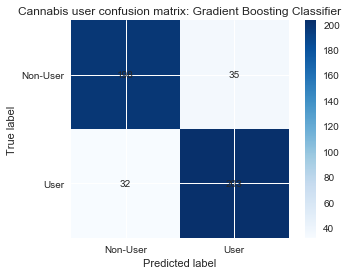

In [70]:
title = 'Cannabis user confusion matrix: Gradient Boosting Classifier'
cm = np.array([[198,35],[32,203]])
classes = ['Non-User', 'User']
cmap = plt.cm.Blues

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
      yticks=np.arange(cm.shape[0]),
      xticklabels=classes,
      yticklabels=classes,
      title=title,
      ylabel='True label',
      xlabel='Predicted label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j]),
               ha="center", va='center')
plt.plot()

### Predicting binary classification (soft drugs, middle drugs, hard drugs)


Searching for optimal classifier by going through every drug. One loop for each class of drugs.

Predicting for soft drugs (alcohol, caffeine, choc, nicotine)

In [83]:
for k in soft_drugs_bin:
    for i in list_classifier:
        catclassifier(k,i)
mean_acc_soft_bin = mean_acc_bin
mean_acc_bin = []

RandomForestClassifier alcohol_user
Accuracy: 0.93
Recall: 0.93
Precision: 0.93
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[  0  33]
 [  0 435]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        33
           1       0.93      1.00      0.96       435

    accuracy                           0.93       468
   macro avg       0.96      0.50      0.48       468
weighted avg       0.93      0.93      0.90       468

GradientBoostingClassifier alcohol_user
Accuracy: 0.93
Recall: 0.93
Precision: 0.93
Accuracy Model: 0.93
Recall Model: 0.93
Precision Model: 0.93
[[  1  32]
 [  0 435]]
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        33
           1       0.93      1.00      0.96       435

    accuracy                           0.93       468
   macro avg       0.97      0.52      0.51       468
weighted avg       0.94      0.93      0.90       468

KNeighborsCl

AdaBoostClassifier choc_user
Accuracy: 0.98
Recall: 0.98
Precision: 0.98
Accuracy Model: 0.97
Recall Model: 0.97
Precision Model: 0.97
[[  0  13]
 [  1 454]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.97      1.00      0.98       455

    accuracy                           0.97       468
   macro avg       0.49      0.50      0.49       468
weighted avg       0.95      0.97      0.96       468

RandomForestClassifier nicotine_user
Accuracy: 0.74
Recall: 0.74
Precision: 0.74
Accuracy Model: 0.76
Recall Model: 0.76
Precision Model: 0.76
[[162  54]
 [ 60 192]]
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       216
           1       0.78      0.76      0.77       252

    accuracy                           0.76       468
   macro avg       0.76      0.76      0.76       468
weighted avg       0.76      0.76      0.76       468

GradientBoostingClassi

Prediction for middle drugs (amyl nitrite, cannabis, ecstasy, ketamine, lsd, legal highs, mushrooms, vsa)

In [ ]:
for k in middle_drugs_bin:
    for i in list_classifier:
        catclassifier(k,i)
mean_acc_mid_bin = mean_acc_bin
mean_acc_bin = []

Prediction for hard drugs (amphetamines, benzodiazepine, cocaine, crack, heroin, meth)

In [ ]:
for k in hard_drugs_bin:
    for i in list_classifier:
        catclassifier(k,i)
mean_acc_hard_bin = mean_acc_bin
mean_acc_bin = []

## Function for multiclass classification

Defining the function for multiclass classification

In [ ]:
cat_features_mult =['age','education','Female','Male','Australia','Canada','New Zealand','Other_country',
                    'Republic of Ireland','UK','USA','Asian','Black','Mixed-Black/Asian','Mixed-White/Asian',
                    'Mixed-White/Black','Other_eth','White']
cat_ordi_features_mult =['alcohol','amphet', 'amyl', 'benzos', 'caff','cannabis', 'choc', 'coke', 'crack', 'ecstasy',
                        'heroin', 'ketamine', 'legalh', 'lsd','meth','shrooms', 'nicotine', 'vsa']

In [ ]:
def multclass(goal,classifier):
    X_train, X_test, y_train, y_test = globals()["X_train_mult_" + str(goal)],globals()["X_test_mult_" + str(goal)],globals()["y_train_mult_" + str(goal)],globals()["y_test_mult_" + str(goal)]
    L=True
    if cat_ordi_features_mult.count(goal) !=0:
        cat_ordi_features_mult.remove(goal)
    if num_features.count(goal) !=0:
        num_features.remove(goal)
        L=False
    model_name = classifier.__class__.__name__
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])
    cat_pipeline = Pipeline([('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing'))
                             ,('1hot', OneHotEncoder(handle_unknown='ignore'))])
    cat_ord_pipeline = Pipeline([('ordi',OrdinalEncoder(categories=[[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6]]))])
    preprocessor = ColumnTransformer([('num', num_pipeline, num_features),('cat', cat_pipeline, cat_features_mult),('cat_ordi',cat_ord_pipeline,cat_ordi_features_mult)])
    pipe = Pipeline([('preprocessor', preprocessor),('params', classifier)])
    y_train_predicted = cross_val_predict(pipe, X_train, y_train, cv=5)
    model = pipe.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)
    print(model_name, goal)
    print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted,average='micro',zero_division=1)))
    print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted,average='micro',zero_division=1)))
    if L==True:
        cat_ordi_features_mult.append(goal)
    if L!=True:
        num_features.append(goal)

In [ ]:
list_multi = [GradientBoostingClassifier(learning_rate=0.01,max_depth=6,max_features=8,min_samples_leaf= 2,n_estimators= 500),
              KNeighborsClassifier(leaf_size= 1,n_neighbors= 26),
              DecisionTreeClassifier(max_depth=7,max_features=8,min_samples_leaf=0.1,min_samples_split=0.1),
              SVC(kernel="rbf", C=1),
              AdaBoostClassifier(learning_rate=0.5,n_estimators=100)
              ]
features_multi = ['cannabis','alcohol','meth','crack','ecstasy']

### Predicting multiclass classification (soft drugs, middle drugs, hard drugs)

Predicting for soft drugs (alcohol, caffeine, choc, nicotine)

In [ ]:
for k in soft_drugs:
    for i in list_multi:
        multclass(k,i)

Prediction for middle drugs (amyl nitrite, cannabis, ecstasy, ketamine, lsd, legal highs, mushrooms, vsa)

In [ ]:
for k in middle_drugs:
    for i in list_multi:
        multclass(k,i)

Prediction for hard drugs (amphetamines, benzodiazepine, cocaine, crack, heroin, meth)

In [ ]:
for k in hard_drugs:
    for i in list_multi:
        multclass(k,i)

## Gridsearch for binary and multiclass classifiers

Definition of parameters for every classifier used

In [ ]:
param_gradbo = {'params__max_depth':[2,4,8],
                'params__learning_rate': [0.01, 0.005,0.015],
                'params__n_estimators':[100, 200],
                'params__min_samples_leaf':[2,3],
                'params__max_features':[2,5,8]
               }
param_kneigh = {'params__leaf_size':list(range(1,50)),
                'params__n_neighbors':list(range(1,30)),
               }
param_dectree = {'params__min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True),
                 'params__max_features':list(range(1,9)),
                 'params__min_samples_split':np.linspace(0.1, 1.0, 5, endpoint=True),
                 'params__max_depth':list(range(1,20))
               }
param_svc = {'params__kernel':["poly","rbf"],
             'params__C':[0.01,0.1,1,10]
               }
param_ada = {'params__learning_rate':[0.01,0.05,0.1,0.5,1.0],
             'params__n_estimators':[50,100,300,1000]
            }
param_logreg = {'params__class_weight':[{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000}],
                'params__max_iter':[4000]
               }

### Gridsearch for binary classification

Function for gridsearch of best parameters for binary classification. Takes the target, to be predicted, the classifier and parameters for the classifier.

In [84]:
def gridclassifier(goal,classifier,params):
    X_train, X_test, y_train, y_test = globals()["X_train_bin_" + str(goal)],globals()["X_test_bin_" + str(goal)],globals()["y_train_bin_" + str(goal)],globals()["y_test_bin_" + str(goal)]
    if cat_features_bin.count(goal) !=0:
        cat_features_bin.remove(goal)
    model_name = classifier.__class__.__name__
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])
    cat_pipeline = Pipeline([('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing'))
                             ,('1hot', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer([('num', num_pipeline, num_features),('cat', cat_pipeline, cat_features_bin)])
    pipe_randfor = Pipeline([('preprocessor', preprocessor),('params', classifier)])
    grid_search = GridSearchCV(pipe_randfor, param_grid=params,verbose=5,scoring="roc_auc", cv=100, n_jobs=-1)
    grid_search.fit(X_train,y_train)
    best_model = grid_search.best_estimator_
    print('Best score:\n{:.2f}'.format(grid_search.best_score_))
    print("Best parameters:\n{}".format(grid_search.best_params_))
    y_train_predicted = cross_val_predict(best_model, X_train, y_train, cv=5)
    y_test_predicted = best_model.predict(X_test)
    print(model_name, goal)
    print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted,average='micro',zero_division=1)))
    print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted,average='micro',zero_division=1)))
    print(confusion_matrix(y_test, y_test_predicted))
    print(classification_report(y_test, y_test_predicted,zero_division=1))
    cat_features_bin.append(goal)

In [ ]:
gridclassifier('amyl_user',LogisticRegression(), param_logreg)

### Gridsearch for multiclass classification

Function for gridsearch of best parameters in multiclass classification. Takes the target, to be predicted, the classifier and parameters for the classifier.

In [85]:
def gridregr(goal,classifier,params):
    X_train, X_test, y_train, y_test = globals()["X_train_mult_" + str(goal)],globals()["X_test_mult_" + str(goal)],globals()["y_train_mult_" + str(goal)],globals()["y_test_mult_" + str(goal)]
    if cat_ordi_features_mult.count(goal) !=0:
        cat_ordi_features_mult.remove(goal)
    model_name = classifier.__class__.__name__
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])
    cat_pipeline = Pipeline([('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing'))
                             ,('1hot', OneHotEncoder(handle_unknown='ignore'))])
    cat_ord_pipeline = Pipeline([('ordi',OrdinalEncoder(categories=[[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6]]))])
    preprocessor = ColumnTransformer([('num', num_pipeline, num_features),('cat', cat_pipeline, cat_features_mult),
                                      ('cat_ordi',cat_ord_pipeline,cat_ordi_features_mult)])
    pipe_randfor = Pipeline([('preprocessor', preprocessor),('params', classifier)])
    grid_search = GridSearchCV(pipe_randfor, param_grid=params, cv=3,verbose=5, n_jobs=-1)
    grid_search.fit(X_train,y_train)
    best_model = grid_search.best_estimator_
    print('Best score:\n{:.2f}'.format(grid_search.best_score_))
    print("Best parameters:\n{}".format(grid_search.best_params_))
    y_train_predicted = cross_val_predict(best_model, X_train, y_train, cv=5)
    y_test_predicted = best_model.predict(X_test)
    print(model_name, goal)
    print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted,average='micro',zero_division=1)))
    print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted,average='micro',zero_division=1)))
    print(confusion_matrix(y_test, y_test_predicted))
    print(classification_report(y_test, y_test_predicted,zero_division=1))
    cat_ordi_features_mult.append(goal)

Searching for the best parameters for each model

In [2]:
gridregr('cannabis', AdaBoostClassifier(), param_ada)

NameError: name 'gridregr' is not defined

## Personal Analysis

### Setup for personal analysis

Defining personal datasets for predicting potential drug usage

In [96]:
perso = pd.DataFrame([[1,6,-3.46436,-2.44904,-3.27393,-1.34289,-2.18109,-0.21712,-0.21575,6,0,0,0,6,0,4,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1]],columns=df.columns)

In [97]:
perso2 = pd.DataFrame([[2,7,-2.34360,-1.92173,-1.27553,-1.62090,-3.46436,2.90161,1.92173,6,0,0,0,6,0,4,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1]],columns=df.columns)

In [98]:
X = df[['age','education','Female','nscore','escore','oscore','ascore','cscore','impulsive','ss']]

In [99]:
X_perso = perso[['age','education','Female','nscore','escore','oscore','ascore','cscore','impulsive','ss']]

### Function for getting recommendations for each substance

In [100]:
def perso_drug(X_perso,model):
    recomm = {}
    for i in drugs:
        y = df[i]
        model.fit(X,y)
        recomm.update({str(i):int(model.predict(X_perso))})
    return recomm

In [101]:
recomm = perso_drug(X_perso,KNeighborsClassifier(10))

Creating new labels for each substance

In [102]:
recomm['alcohol'] = recomm.pop('alcohol')
recomm['amphetamin'] = recomm.pop('amphet')
recomm['amyl nitrite'] = recomm.pop('amyl')
recomm['benzodiazepin'] = recomm.pop('benzos')
recomm['caffeine'] = recomm.pop('caff')
recomm['cannabis'] = recomm.pop('cannabis')
recomm['chocolate'] = recomm.pop('choc')
recomm['cocaine'] = recomm.pop('coke')
recomm['crack'] = recomm.pop('crack')
recomm['ecstasy'] = recomm.pop('ecstasy')
recomm['heroin'] = recomm.pop('heroin')
recomm['ketamine'] = recomm.pop('ketamine')
recomm['legal highs'] = recomm.pop('legalh')
recomm['lsd'] = recomm.pop('lsd')
recomm['meth'] = recomm.pop('meth')
recomm['mushrooms'] = recomm.pop('shrooms')
recomm['nicotine'] = recomm.pop('nicotine')
recomm['vsa'] = recomm.pop('vsa')

### Plotting results from the personality test

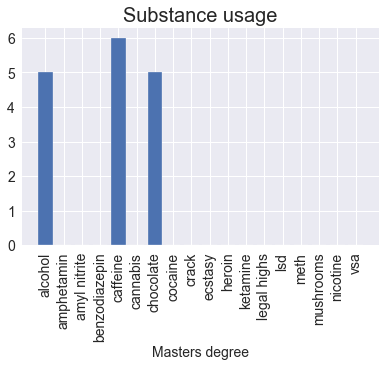

In [103]:
plt.figure(figsize=(6.4,4))
plt.rc('xtick', labelsize=14,)
plt.rc('ytick', labelsize=14,)
plt.bar(range(len(recomm)), recomm.values(), align='center')
plt.xlabel('Masters degree',fontdict={'fontsize':14})
plt.title('Substance usage', fontdict={'fontsize':20})
plt.xticks(range(len(recomm)), list(recomm.keys()),rotation=90)
plt.show()

# Future work

- Function for imbalanced binary classification using SMOTE

- Focus on feature importance

- Developing an easy to use implementation for the substance “recommendation”


Questions to answer:

- What kind of substances are becoming less interesting over time?


# Appendix

## Score translation functions

In [35]:
def nscore_translator(n):
    '''
    GIves you the correlating z score to any n score and vice versa.
    If n is a float it will be seen as a z score and be translated into a n score.
    Returns False if translation can't be made.
    '''    

    dns = {12 : -3.46436,
    13 : -3.15735 ,
    30 : -0.58016 ,
    47 : 1.13281,
    14 : -2.75696, 
    31 : -0.46725 ,
    48 : 1.23461,
    15 : -2.52197,
    32 : -0.34799 ,
    49 : 1.37297,
    16 : -2.42317, 
    33 : -0.24649,
    50 : 1.49158,
    17 : -2.34360, 
    34 : -0.14882 ,
    51 : 1.60383,
    18 : -2.21844, 
    35 : -0.05188 ,
    52 : 1.72012,
    19 : -2.05048, 
    36 : 0.04257 ,
    53 : 1.83990,
    20 : -1.86962, 
    37 : 0.13606 ,
    54 : 1.98437,
    21 : -1.69163, 
    38 : 0.22393 ,
    55 : 2.12700,
    22 : -1.55078, 
    39 : 0.31287 ,
    56 : 2.28554,
    23 : -1.43907, 
    40 : 0.41667 ,
    57 : 2.46262,
    24 : -1.32828, 
    41 : 0.52135 ,
    58 : 2.61139,
    25 : -1.19430, 
    42 : 0.62967 ,
    59 : 2.82196,
    26 : -1.05308, 
    43 : 0.73545 ,
    60 : 3.27393,
    27 : -0.92104, 
    44 : 0.82562,
    28 : -0.79151, 
    45 : 0.91093,
    29 : -0.67825, 
    46 : 1.02119}
    
    returnee = False
    if type(n) == int  and (n in dns.keys()):
        returnee = dns[n]
    else:
        if n in dns.values():
            for key, value in dns.items():
                if value == n:
                    returnee = key
    return returnee

def escore_translator(n):
    '''
    GIves you the correlating z score to any n score and vice versa.
    If n is a float it will be seen as a z score and be translated into a n score.
    Returns False if translation can't be made.
    '''    
    des = {16 : -3.27393, 31 : -1.23177, 45 : 0.80523,
    18 : -3.00537, 32 : -1.09207, 46 : 0.96248,
    19 : -2.72827, 33 : -0.94779, 47 : 1.11406,
    20 : -2.53830, 34 : -0.80615, 48 : 1.28610,
    21 : -2.44904, 35 : -0.69509, 49 : 1.45421,
    22 : -2.32338, 36 : -0.57545, 50 : 1.58487,
    23 : -2.21069, 37 : -0.43999, 51 : 1.74091,
    24 : -2.11437, 38 : -0.30033, 52 : 1.93886,
    25 : -2.03972, 39 : -0.15487, 53 : 2.12700,
    26 : -1.92173, 40 : 0.00332, 54 : 2.32338,
    27 : -1.76250, 41 : 0.16767, 55 : 2.57309,
    28 : -1.63340, 42 : 0.32197, 56 : 2.85950,
    29 : -1.50796, 43 : 0.47617, 58 : 3.00537,
    30 : -1.37639, 44 : 0.63779, 59 : 3.27393}
    
    returnee = False
    if type(n) == int  and (n in des.keys()):
        returnee = des[n]
    else:
        if n in dns.values():
            for key, value in des.items():
                if value == n:
                    returnee = key
    return returnee

def oscore_translator(n):
    '''
    GIves you the correlating z score to any n score and vice versa.
    If n is a float it will be seen as a z score and be translated into a n score.
    Returns False if translation can't be made.
    '''    
    des = {24 : -3.27393, 38 : -1.11902, 50 : 0.58331,
    26 : -2.85950, 39 : -0.97631, 51 : 0.72330,
    28 : -2.63199, 40 : -0.84732, 52 : 0.88309,
    29 : -2.39883, 41 : -0.71727, 53 : 1.06238,
    30 : -2.21069, 42 : -0.58331, 54 : 1.24033,
    31 : -2.09015, 43 : -0.45174, 55 : 1.43533,
    32 : -1.97495, 44 : -0.31776, 56 : 1.65653,
    33 : -1.82919, 45 : -0.17779, 57 : 1.88511,
    34 : -1.68062, 46 : -0.01928, 58 : 2.15324,
    35 : -1.55521, 47 : 0.14143 ,59 : 2.44904,
    36 : -1.42424, 48 : 0.29338, 60 : 2.90161,
    37 : -1.27553, 49 : 0.44585}
    
    returnee = False
    if type(n) == int  and (n in des.keys()):
        returnee = des[n]
    else:
        if n in dns.values():
            for key, value in des.items():
                if value == n:
                    returnee = key
    return returnee

def ascore_translator(n):
    '''
    GIves you the correlating z score to any n score and vice versa.
    If n is a float it will be seen as a z score and be translated into a n score.
    Returns False if translation can't be made.
    '''    
    des = {12 : -3.46436, 34 : -1.34289, 48 : 0.76096,
    16 : -3.15735, 35 : -1.21213, 49 : 0.94156,
    18 : -3.00537, 36 : -1.07533, 50 : 1.11406,
    23 : -2.90161, 37 : -0.91699, 51 : 1.2861,
    24 : -2.78793, 38 : -0.76096, 52 : 1.45039,
    25 : -2.70172, 39 : -0.60633, 53 : 1.61108,
    26 : -2.53830, 40 : -0.45321, 54 : 1.81866,
    27 : -2.35413, 41 : -0.30172, 55 : 2.03972,
    28 : -2.21844, 42 : -0.15487, 56 : 2.23427,
    29 : -2.07848, 43 : -0.01729, 57 : 2.46262,
    30 : -1.92595, 44 : 0.13136, 58 : 2.75696,
    31 : -1.77200, 45 : 0.28783, 59 : 3.15735,
    32 : -1.62090, 46 : 0.43852, 60 : 3.46436,
    33 : -1.47955, 47 : 0.59042}
           
    returnee = False
    if type(n) == int  and (n in des.keys()):
        returnee = des[n]
    else:
        if n in dns.values():
            for key, value in des.items():
                if value == n:
                    returnee = key
    return returnee

def cscore_translator(n):
    '''
    GIves you the correlating z score to any n score and vice versa.
    If n is a float it will be seen as a z score and be translated into a n score.
    Returns False if translation can't be made.
    '''    
    des = {17 : -3.46436, 32 : -1.25773, 46 : 0.58489,
    19 : -3.15735, 33 : -1.13788, 47 : 0.7583,
    20 : -2.90161, 34 : -1.01450, 48 : 0.93949,
    21 : -2.72827, 35 : -0.89891, 49 : 1.13407,
    22 : -2.57309, 36 : -0.78155, 50 : 1.30612,
    23 : -2.42317, 37 : -0.65253, 51 : 1.46191,
    24 : -2.30408, 38 : -0.52745, 52 : 1.63088,
    25 : -2.18109, 39 : -0.40581, 53 : 1.81175,
    26 : -2.04506, 40 : -0.27607, 54 : 2.04506,
    27 : -1.92173, 41 : -0.14277, 55 : 2.33337,
    28 : -1.78169, 42 : -0.00665, 56 : 2.63199,
    29 : -1.64101, 43 : 0.12331, 57 : 3.00537,
    30 : -1.51840, 44 : 0.25953, 59 : 3.46436,
    31 : -1.38502, 45 : 0.41594}
           
    returnee = False
    if type(n) == int  and (n in des.keys()):
        returnee = des[n]
    else:
        if n in dns.values():
            for key, value in des.items():
                if value == n:
                    returnee = key
    return returnee



In [36]:
nscore_translator(80)

False